In [1]:
#Paquetes utilizados
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas import Series
import matplotlib as mpl
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
import math
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error
from scipy.stats import kstest, norm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import normaltest
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_arch
from scipy import stats

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
ts = pd.read_excel("loadsts.xlsx")
ts.index= ts['Posted_date']
ts = ts['Loads']
ts

Posted_date
2021-01-24      5
2021-01-31      9
2021-02-07    169
2021-02-14    159
2021-02-21    176
             ... 
2024-06-30    227
2024-07-07    162
2024-07-14    226
2024-07-21    237
2024-07-28    235
Name: Loads, Length: 184, dtype: int64

# separacion training validation testing

In [3]:
def split(serie, trainportion):
    perct = math.ceil(len(ts) * trainportion)
    perc2 = math.ceil(len(ts)*((1 - trainportion)/2))
    train = serie[0:perct]
    validation = serie[perct:perct+perc2]
    test = serie[perct+perc2:]
    return train, validation, test

In [4]:
train, validation, test = split(ts, 0.7)

In [5]:
#seleccion del mape como metrica de error

## suavizacion primer orden

In [6]:
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

In [8]:
best_mape=900
fsresults=pd.DataFrame()
T = len(train) #longitud del training
tau = len(validation) # tiempo que se va a pronosticar
cpi_forecast = np.zeros(tau) 
cpi_smooth1 = np.zeros(T + tau)
cpi_smooth2 = np.zeros(T + tau)
cpi_dates = ts

for lambda_ in np.arange(0, 0.95, 0.05):
    trainfs = firstsmooth(train, lambda_)
    mape = 100*(sum(abs(((train - trainfs)/train)))/len(train))
    if mape<best_mape:
        best_mape=mape
        model=trainfs
        ls = lambda_
        
fsresults["Model"] = "first_smooth"

In [74]:
best_mape=900
results=[]

for lambda_ in np.arange(0, 0.95, 0.05):
    trainfs = firstsmooth(train, lambda_)
    mape = 100*(sum(abs(((train - trainfs)/train)))/len(train))
    if  mape<best_mape:
        best_mape = mape
        model=trainfs2
        ls = lambda_
    results.append(mape)
    
fsresults = pd.DataFrame({"lambda":np.arange(0,0.95,0.05),"mape":results})
fsresults["Model"] = "first_smooth"

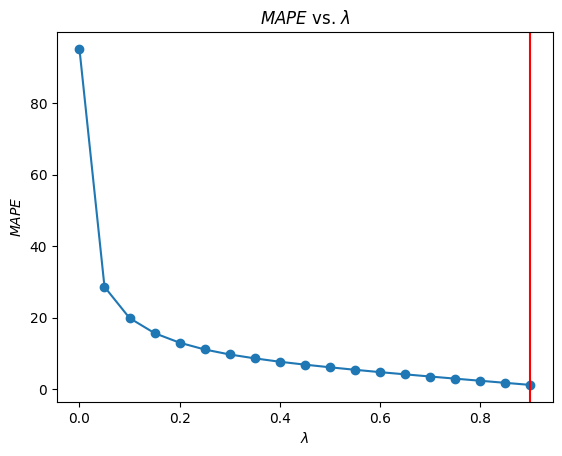

In [76]:
plt.plot(fsresults["lambda"], fsresults["mape"], marker='o', linestyle='-')
plt.title("$MAPE$ vs. $\lambda$")
plt.xlabel('$\lambda$')
plt.ylabel('$MAPE$')
plt.axvline(x=ls, color='red')
plt.show()

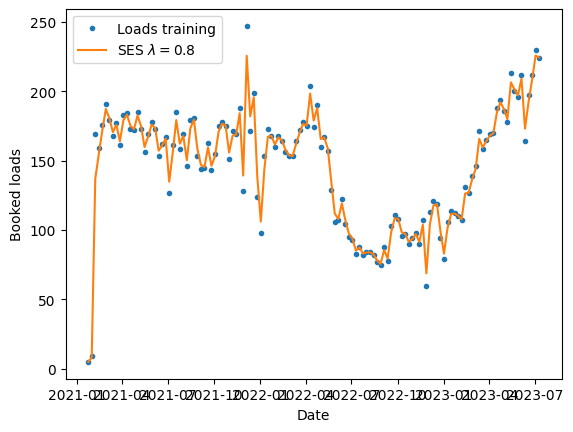

In [11]:
plt.plot(train, marker='o', linestyle='', markersize=3, label='Loads training')
plt.plot(model, label='SES $\lambda=0.8$')
plt.xlabel('Date')
plt.ylabel('Booked loads')
plt.legend()
plt.show()

## suavizacion segundo orden

In [43]:
mape=900
fs2results=pd.DataFrame()
for lambda_ in np.arange(0, 0.95, 0.05):
    trainfs = firstsmooth(y=train, lambda_=lambda_)
    trainfs2 = firstsmooth(y=trainfs, lambda_=lambda_)
    trainfs2 = 2 * trainfs - trainfs2
    mape = 100*(sum(abs(((validation - cpi_forecast)/validation)))/len(validation))
    if ret1['MAPE'][0]<mape:
        mape=ret1['MAPE'][0]
        model=trainfs2
        ls = lambda_
    fs2results = pd.concat([fs2results, ret1], axis=0, ignore_index=True)
fs2results["Model"] = "second_smooth"

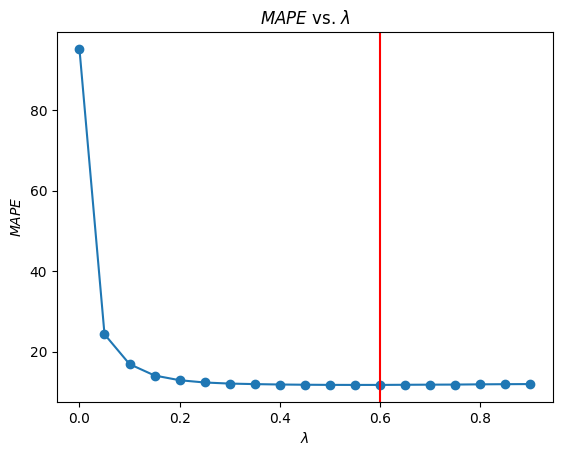

In [44]:
plt.plot(fs2results["lambda"], fs2results["MAPE"], marker='o', linestyle='-')
plt.title("$MAPE$ vs. $\lambda$")
plt.xlabel('$\lambda$')
plt.ylabel('$MAPE$')
plt.axvline(x=ls, color='red')
plt.show()

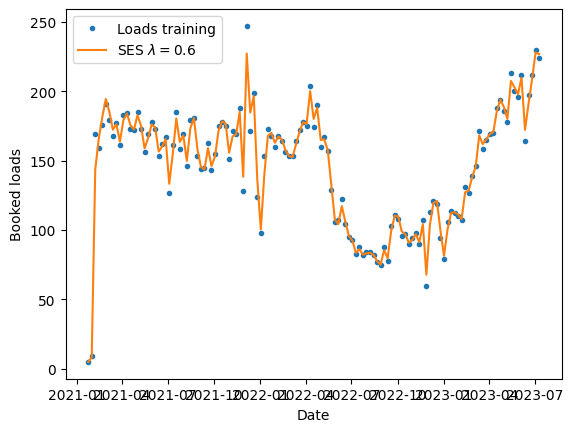

In [49]:
plt.plot(train.index,train, marker='o', linestyle='', markersize=3, label='Loads training')
plt.plot(train.index,model, label='SES $\lambda=0.6$')
plt.xlabel('Date')
plt.ylabel('Booked loads')
plt.legend()
plt.show()

In [71]:
lambda_ = 0.8 #factor de suavizacion
T = len(train) #longitud del training
tau = len(validation) # tiempo que se va a pronosticar
alpha_lev = 0.05 #significancia para los intervalos de prediccion
cpi_forecast = np.zeros(tau) 
cl = np.zeros(tau)
cpi_smooth1 = np.zeros(T + tau)
cpi_smooth2 = np.zeros(T + tau)
cpi_dates = ts

for i in range(1, tau + 1):
    cpi_smooth1[:T + i - 1] = firstsmooth(y=cpi_dates.iloc[:T + i - 1], lambda_=lambda_)
    cpi_smooth2[:T + i - 1] = firstsmooth(y=cpi_smooth1[:T + i - 1], lambda_=lambda_)
    display(cpi_smooth1)
    cpi_forecast[i - 1] = (2 + (lambda_ / (1 - lambda_))) * cpi_smooth1[T + i - 2] - \
                          (1 + (lambda_ / (1 - lambda_))) * cpi_smooth2[T + i - 2] # horizon one each time
    #cpi_hat = 2 * cpi_smooth1[:T + i - 1] - cpi_smooth2[:T + i - 1]
    #cig_est = np.sqrt(np.var(cpi_dates.iloc[1:T + i - 1] - cpi_hat[:-1]))
    #cl[i - 1] = norm.ppf(1 - alpha_lev / 2) * sig_est

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

array([  5.        ,   8.2       , 136.84      , 154.568     ,
       171.7136    , 187.14272   , 180.628544  , 170.5257088 ,
       175.70514176, 163.94102835, 179.18820567, 183.03764113,
       175.00752823, 172.60150565, 182.52030113, 174.90406023,
       159.78081205, 167.15616241, 175.83123248, 173.5662465 ,
       157.1132493 , 161.02264986, 165.80452997, 134.76090599,
       155.7521812 , 179.15043624, 162.23008725, 167.64601745,
       150.32920349, 173.2658407 , 179.45316814, 158.29063363,
       146.85812673, 145.37162535, 159.47432507, 146.29486501,
       153.258973  , 170.6517946 , 176.53035892, 175.30607178,
       155.86121436, 167.97224287, 168.79444857, 184.15888971,
       139.23177794, 225.44635559, 181.88927112, 195.57785422,
       138.31557084, 106.06311417, 143.61262283, 167.12252457,
       167.82450491, 161.56490098, 166.7129802 , 164.54259604,
       157.70851921, 153.94170384, 153.18834077, 161.83766815,
       169.96753363, 176.39350673, 175.27870135, 198.25

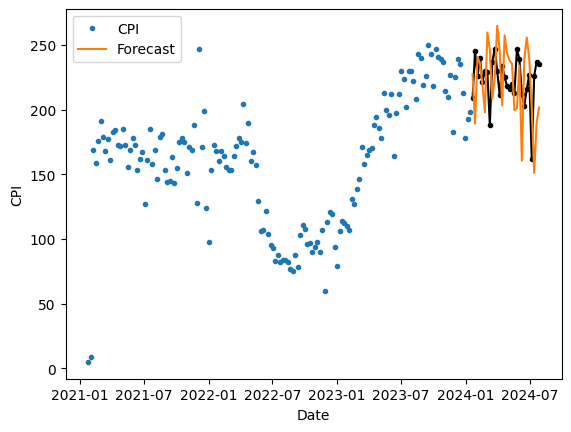

In [16]:
plt.figure()
plt.plot(cpi_dates.index[:-tau], cpi_dates.iloc[:-tau].values, marker='o', linestyle='', markersize=3, label='CPI')
plt.plot(cpi_dates.index[-tau:], cpi_dates.iloc[-tau:].values, marker='o', markersize=3, color='black')
plt.plot(cpi_dates.index[-tau:], cpi_forecast, label='Forecast')
#plt.plot(cpi_dates.index[-tau:], cpi_forecast + cl, linestyle='--', color='red', label='Confidence Interval')
#plt.plot(cpi_dates.index[-tau:], cpi_forecast - cl, linestyle='--', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

In [ ]:
mape=100*(sum(abs(((validation - cpi_forecast)/validation)))/len(validation))

10.649076075406398

In [ ]:
#error pronostico validacion
#mape

## holt winters

## arima

In [17]:
#seleccion metrica de modelo en arima HQIC

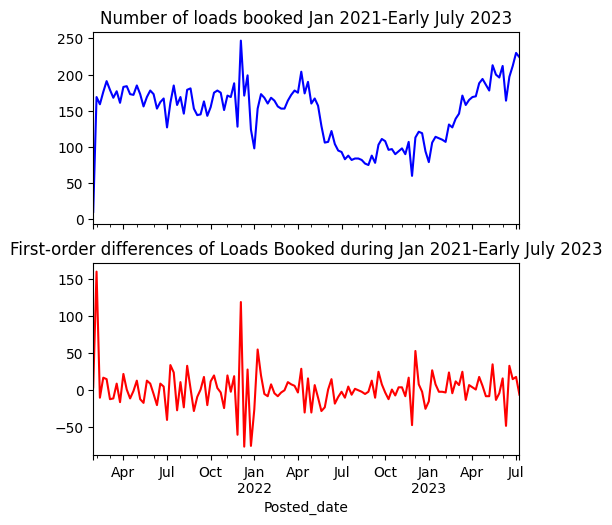

In [18]:
train_diff = train.diff(1).dropna()
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(5.5, 5.5)
train.plot(ax=ax[0], color='b')
ax[0].set_title('Number of loads booked Jan 2021-Early July 2023')
train_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-order differences of Loads Booked during Jan 2021-Early July 2023');

In [19]:
#H0: La serie no es estacionaria
#H1: La serie es estacionaria
adf_result = adfuller(train_diff.dropna(), autolag='AIC')
adf_result[1]

1.1653730556084752e-12

<Figure size 550x550 with 0 Axes>

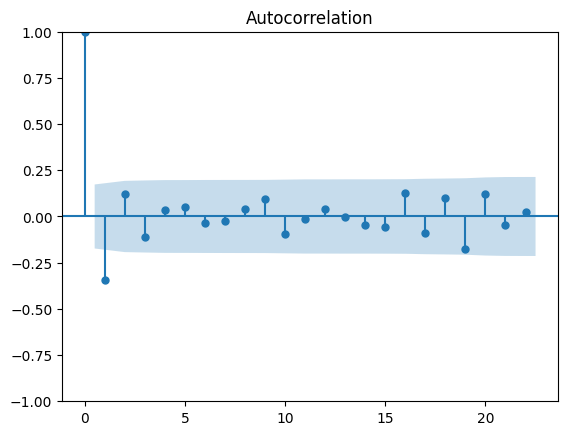

In [20]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train_diff);

<Figure size 550x550 with 0 Axes>

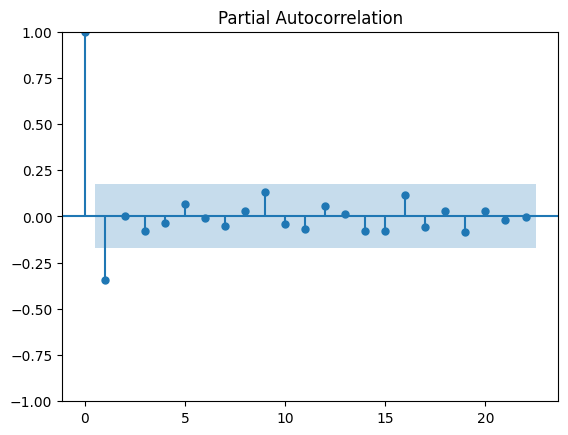

In [21]:
plt.figure(figsize=(5.5, 5.5));
plot_pacf(train_diff);

In [24]:
def td_array(col):
    s = []
    for i in col:
        a = [1,i]
        s.append(a)
    return (np.array(s))

def assumptions(fit):
    
    """
    
    Test the errors' assumptions for the VAR Model created.
    
    Args:
        fit (Model): ARIMA Model to test.
        
    Returns:
    
        a (Integer): Number of tests that the residuals don't pass.
        warning (String): Description of the errors' assumptions tests.
        
    """
        
    a=0
    residuals=fit.resid
    
    ci=[0.05,0.1,0.15,0.2,0.25]
    
    for pv in ci:

        warning=""
        
        b_model = td_array(train)
        
        #homocedasticity
        #H0: The residuals are homocedastic.
        #H1: The residuals aren't homocedastic.
        _, bp_pvalue, _, _ = het_breuschpagan(residuals, b_model)
        if bp_pvalue<0.05:
            warning=warning + " The residuals aren't homocedastic"
            a=a+1  
            
        #normality test
        #H0: The residuals have a normal distribution.
        #H1: The residuals don't have a normal distribution.
        stat, p = shapiro(residuals)
        if p<0.05:
            stat, p = kstest(residuals, 'norm')
            if p<0.05:
                a=a+1
                warning = warning + " The residuals do not follow a normal distribution"
        
        #independency
        #H0: The residuals are independent.
        #H1: The residuals aren't independent.
        out = durbin_watson(residuals)
        if out < 1.5 and out >=2.5:
            a=a+1
            warning = warning + " The residuals aren't independent"
        
        if a==0:
            warning = "The assumptions made about the residuals are verified with a confidence of " + str(1-pv) + "."
            break
            
    warning = warning + " in none of the confidence levels."
        
    return a,warning

In [25]:
hqicVal=[]
for ari in range(0, 3): #p
    for maj in range(0,3): #q
        try:
            arima_obj = smtsa.ARIMA(train, order=(ari, 0, maj))
            arima_obj_fit=arima_obj.fit()
            a, warning = assumptions(arima_obj_fit)
            hqicVal.append([ari, 0, maj, arima_obj_fit.hqic, arima_obj_fit.aic, warning])
            
        except ValueError:
            pass

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency 

In [26]:
dfHQIC = pd.DataFrame(hqicVal, columns=['AR(p)', 'd', 'MA(q)', 'HQIC', 'AIC', 'Residuals'])
dfHQIC

,AR(p),d,MA(q),HQIC,AIC,Residuals
0,0,0,0,1341.957086,1339.633087,The residuals aren't homocedastic The residua...
1,0,0,1,1282.418192,1278.932193,The residuals aren't homocedastic The residua...
2,0,0,2,1246.384495,1241.736496,The residuals do not follow a normal distribu...
3,1,0,0,1219.134168,1215.648169,The residuals do not follow a normal distribu...
4,1,0,1,1213.811186,1209.163187,The residuals do not follow a normal distribu...
5,1,0,2,1216.574472,1210.764474,The residuals do not follow a normal distribu...
6,2,0,0,1212.948804,1208.300805,The residuals do not follow a normal distribu...
7,2,0,1,1215.879361,1210.069362,The residuals do not follow a normal distribu...
8,2,0,2,1218.926799,1211.954801,The residuals do not follow a normal distribu...


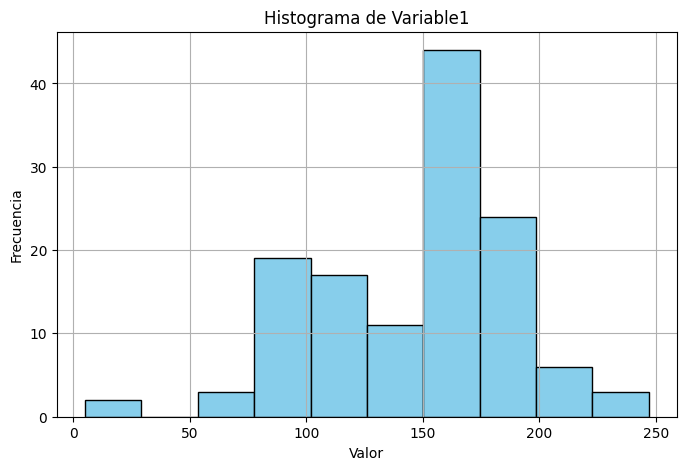

In [27]:
# Generar el histograma de la columna 'Variable1'
plt.figure(figsize=(8, 5))  # Tamaño de la figura
plt.hist(train, bins=10, color='skyblue', edgecolor='black')  # Crear histograma
plt.title('Histograma de Variable1')  # Título del gráfico
plt.xlabel('Valor')  # Etiqueta del eje X
plt.ylabel('Frecuencia')  # Etiqueta del eje Y
plt.grid(True)  # Mostrar cuadrícula
plt.show()  # Mostrar gráfico

In [28]:
ts_log = np.log(ts)

In [29]:
train, validation, test = split(ts_log, 0.7)

In [30]:
hqicVal=[]
for ari in range(0, 3): #p
    for maj in range(0,3): #q
        try:
            arima_obj = smtsa.ARIMA(train, order=(ari, 0, maj))
            arima_obj_fit=arima_obj.fit()
            a, warning = assumptions(arima_obj_fit)
            hqicVal.append([ari, 0, maj, arima_obj_fit.hqic, arima_obj_fit.aic, warning])
            
        except ValueError:
            pass

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency 

In [31]:
dfHQIC = pd.DataFrame(hqicVal, columns=['AR(p)', 'd', 'MA(q)', 'HQIC', 'AIC', 'Residuals'])
dfHQIC

,AR(p),d,MA(q),HQIC,AIC,Residuals
0,0,0,0,182.690849,180.366850,The residuals aren't homocedastic The residua...
1,0,0,1,109.432486,105.946487,The residuals aren't homocedastic The residua...
2,0,0,2,90.473725,85.825727,The residuals aren't homocedastic The residua...
3,1,0,0,73.935098,70.449099,The residuals aren't homocedastic The residua...
4,1,0,1,76.426178,71.778180,The residuals aren't homocedastic The residua...
5,1,0,2,78.357143,72.547145,The residuals aren't homocedastic The residua...
6,2,0,0,76.322250,71.674252,The residuals aren't homocedastic The residua...
7,2,0,1,77.768189,71.958191,The residuals aren't homocedastic The residua...
8,2,0,2,81.474583,74.502585,The residuals aren't homocedastic The residua...


In [32]:
ts_boxcox=stats.boxcox(ts)
train, validation, test = split(ts_boxcox[0], 0.7)

In [33]:
hqicVal=[]

for ari in range(0, 3): #p
    for maj in range(0,3): #q
        try:
            arima_obj = smtsa.ARIMA(train, order=(ari, 0, maj))
            arima_obj_fit=arima_obj.fit()
            a, warning = assumptions(arima_obj_fit)
            hqicVal.append([ari, 0, maj, arima_obj_fit.hqic, arima_obj_fit.aic, warning])
            
        except ValueError:
            pass

In [34]:
dfHQIC = pd.DataFrame(hqicVal, columns=['AR(p)', 'd', 'MA(q)', 'HQIC', 'AIC', 'Residuals'])
dfHQIC

,AR(p),d,MA(q),HQIC,AIC,Residuals
0,0,0,0,1831.884950,1829.560951,The residuals do not follow a normal distribu...
1,0,0,1,1776.943240,1773.457241,The residuals do not follow a normal distribu...
2,0,0,2,1737.822849,1733.174850,The residuals do not follow a normal distribu...
3,1,0,0,1713.070755,1709.584756,The residuals do not follow a normal distribu...
4,1,0,1,1702.538744,1697.890745,The residuals do not follow a normal distribu...
5,1,0,2,1705.121351,1699.311352,The residuals do not follow a normal distribu...
6,2,0,0,1701.103673,1696.455674,The residuals do not follow a normal distribu...
7,2,0,1,1704.157060,1698.347062,The residuals do not follow a normal distribu...
8,2,0,2,1707.063147,1700.091149,The residuals do not follow a normal distribu...


## SARIMA

In [36]:
ts_seasonal = seasonal_decompose(ts, period = 4, model='additive').seasonal

#H0: La serie no es estacionaria
#H1: La serie es estacionaria
adf_result = adfuller(ts_seasonal.dropna(), autolag='AIC')
adf_result[1] #D =0

0.0

<Figure size 550x550 with 0 Axes>

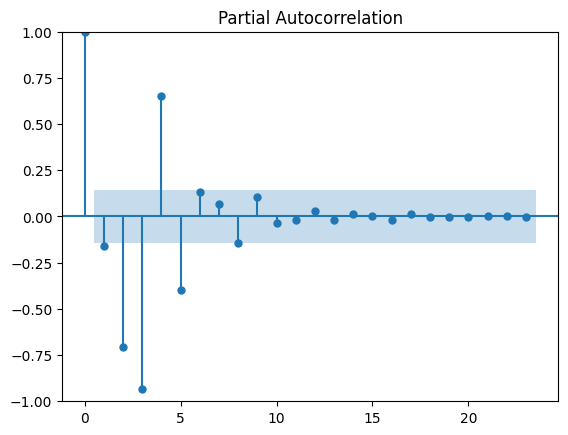

In [37]:
plt.figure(figsize=(5.5, 5.5));
plot_pacf(ts_seasonal);
#p 1-5

<Figure size 550x550 with 0 Axes>

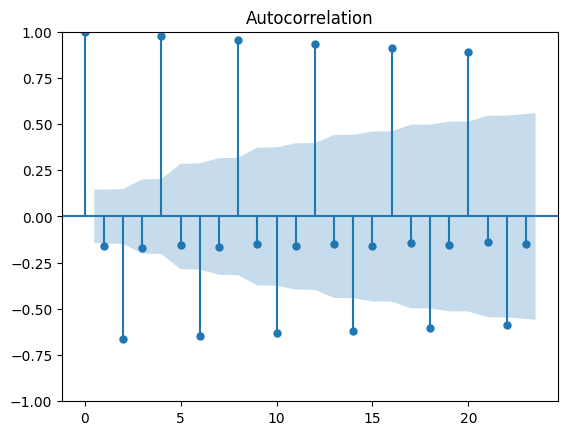

In [38]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(ts_seasonal);
#q 2, 4, 6

In [39]:
train, validation, test = split(ts, 0.7)

In [41]:
mod = sm.tsa.statespace.SARIMAX(train, trend='n', order=(1, 1, 1),
                                seasonal_order=(5, 0, 2, 2)).fit()

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [42]:
assumptions(mod)

(5,
 ' The residuals do not follow a normal distribution in none of the confidence levels.')

## modelo literatura

In [ ]:
#modelos suavizacion holt winters
#suavizacion exponencial simpe
#suavizacion exponencial doble
#suavizacion exponencial triple
#revisar distribucion normal
#tabla con resultados de cada modelo